To Do:
1. Invariant mass plot with data and background
2. Add higgs, signal
3. Add cross-section to all background and signal
4. Apply blinding
5. Match data and MC
6. Apply selection cuts.

In [1]:
#genWeights plotting 


In [2]:
# import ROOT

# def process_genweights(file_path, tree_name):
#     file_1 = ROOT.TFile(file_path, "READ")
#     tree = file_1.Get(tree_name)
#     genweights = []

#     if not tree:
#         print(f"Tree not found in file: {file_path}")
#         return genweights

#     for event in tree:
#         if hasattr(event, 'genWeight'):
#             genweights.append(event.genWeight)
    
#     file_1.Close()
#     return genweights

# background_files = [
#     ("../../output_root/GluGluToHH.root", "GluGluToHH"),
# ]

# tree_name = "DiphotonTree/data_125_13TeV_NOTAG"

# background_genweights = {}

# # Process GGJets file
# background_file, bg_name = background_files[0]
# genweights = process_genweights(background_file, tree_name)
# background_genweights[bg_name] = genweights

# # Create histogram
# hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Genweights", 50, min(genweights), max(genweights))
# for weight in genweights:
#     hist.Fill(weight)

# # Plotting
# canvas = ROOT.TCanvas("canvas", "Genweights", 800, 600)
# hist.Draw()
# hist.GetXaxis().SetTitle("GenWeight")
# hist.GetYaxis().SetTitle("Events")
# canvas.Update()
# canvas.SetLogy()
# canvas.Draw()
# canvas.SaveAs("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/genWeights/signal_genweights.pdf")
# canvas.SaveAs("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/genWeights/signal_genweights.png")


In [5]:
import ROOT

Welcome to JupyROOT 6.30/02


In [16]:
def create_lorentz_vector(pt, eta, phi, m):
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiM(pt, eta, phi, m)
    return lv

def process_file(file_path, tree_name):
    # Open the ROOT file in read mode
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)

    # Array to store the invariant mass values, genWeights, and weight_central
    invariant_masses = []
    gen_weights = []
    weight_central_values = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            if not hasattr(event, 'lead_bjet_pt') or not hasattr(event, 'lead_bjet_eta') or not hasattr(event, 'lead_bjet_phi') or not hasattr(event, 'lead_bjet_mass') or not hasattr(event, 'sublead_bjet_pt') or not hasattr(event, 'sublead_bjet_eta') or not hasattr(event, 'sublead_bjet_phi') or not hasattr(event, 'sublead_bjet_mass'):
                continue

            lead_bjet_pt = event.lead_bjet_pt
            lead_bjet_eta = event.lead_bjet_eta
            lead_bjet_phi = event.lead_bjet_phi
            lead_bjet_mass = event.lead_bjet_mass
            sublead_bjet_pt = event.sublead_bjet_pt
            sublead_bjet_eta = event.sublead_bjet_eta
            sublead_bjet_phi = event.sublead_bjet_phi
            sublead_bjet_mass = event.sublead_bjet_mass
            gen_weight = getattr(event, 'genWeight', 1)  # Use 1 if genWeight is not available
            weight_central = getattr(event, 'weight_central', 1)  # Use 1 if weight_central is not available

            # Create Lorentz vectors for the lead and sublead b-jets
            lv1 = create_lorentz_vector(lead_bjet_pt, lead_bjet_eta, lead_bjet_phi, lead_bjet_mass)
            lv2 = create_lorentz_vector(sublead_bjet_pt, sublead_bjet_eta, sublead_bjet_phi, sublead_bjet_mass)

            # Calculate the total Lorentz vector
            lv = lv1 + lv2

            # Get the invariant mass
            invariant_mass = lv.M()

            # Store the invariant mass, genWeight, and weight_central
            invariant_masses.append(invariant_mass)
            gen_weights.append(gen_weight)
            weight_central_values.append(weight_central)

    # Close the ROOT file
    file_1.Close()

    # Return the invariant mass values, genWeights, and weight_central
    return invariant_masses, gen_weights, weight_central_values


In [17]:
# Data file paths
data_file_paths = [
    "../../output_root/Data_EraE.root",
    "../../output_root/Data_EraF.root",
    "../../output_root/Data_EraG.root"
]

# Process background files
background_files = [
    ("../../output_root/GGJets.root", "GGJets"),
    ("../../output_root/GJetPt20To40.root", "GJetPt20To40"),
    ("../../output_root/GJetPt40.root", "GJetPt40"),
    ("../../output_root/GluGluHToGG.root", "GluGluHToGG"),
    ("../../output_root/ttHToGG.root", "ttHToGG"),
    ("../../output_root/VBFHToGG.root", "VBFHToGG"),
    ("../../output_root/VHToGG.root", "VHToGG")
]

# Define the signal file path
signal_file = "../../output_root/GluGluToHH.root"




# Tree and variable names
tree_name = "DiphotonTree/data_125_13TeV_NOTAG"

# Branching ratio
BR_HToGG = 2.270E-03
BR_HTobb = 	5.824E-01
BR_HTogg =  2.270E-03

# Cross sections for backgrounds and signal
cross_sections = {
    "GGJets": 88.75,
    "GJetPt20To40": 242.5,
    "GJetPt40": 919.1,
    "GluGluHToGG": 52.23 * BR_HToGG,  # Check it!!
#     "ttHToGG": 0.0013 * BR_HToGG ,
#     "VBFHToGG": 0.00926 * BR_HToGG,
#     "VHToGG": 0.00545 * BR_HToGG,
    "ttHToGG": 0.0013  ,
    "VBFHToGG": 0.00926 ,
    "VHToGG": 0.00545,
    "GluGluToHH":  34.43 * BR_HTobb * BR_HTogg * 2   # 0.1186     #0.1186   # ~34fb*BR(H-bb)*BR(H-gg)*2  = ~ 0.26% Check it!!
}



integrated_luminosities = {
    "Data_EraE": 5.8070,
    "Data_EraF": 17.7819,
    "Data_EraG": 3.0828
}



In [18]:
# Total integrated luminosity
total_integrated_luminosity = sum(integrated_luminosities.values())
total_integrated_luminosity

26.6717

In [12]:
# Process data files
data_invariant_masses = []
for data_file_path in data_file_paths:
    data_invariant_masses.extend(process_file(data_file_path, tree_name))


KeyboardInterrupt: 

In [19]:
#  Process data files
data_invariant_masses = []
for data_file_path in data_file_paths:
    masses = process_file(data_file_path, tree_name)  # Ignore the weights
    data_invariant_masses.extend(masses)


In [24]:
# Process data files
data_invariant_masses = []
for data_file_path in data_file_paths:
    masses, _, _ = process_file(data_file_path, tree_name)  # Ignore the weights
    data_invariant_masses.extend(masses)

### previous working code

In [20]:
# # Process background files and create histograms
# background_hists = {}
# hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
# rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]

# for i, (background_file, bg_name) in enumerate(background_files):
#     bg_invariant_masses, bg_weights = process_file(background_file, tree_name)
#     bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
#     total_gen_weight = sum(bg_weights)
#     cross_section = cross_sections[bg_name]
#     for mass, weight in zip(bg_invariant_masses, bg_weights):
#         adjusted_weight = (weight * total_integrated_luminosity * cross_section) #/ total_gen_weight # Divide by weight_central 
#         bg_hist.Fill(mass, adjusted_weight)
#     r, g, b = rgb_colors[i]
#     bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
#     background_hists[bg_name] = bg_hist

# # Combine Higgs backgrounds into one
# higgs_backgrounds = ["GluGluHToGG", "ttHToGG", "VBFHToGG", "VHToGG"]
# combined_higgs_hist = ROOT.TH1F("hist_Higgs", "Higgs (#rightarrow #gamma#gamma) Invariant Mass", 20, 80, 180)
# for bg_name in higgs_backgrounds:
#     bg_hist = background_hists.get(bg_name)
#     if bg_hist:
#         combined_higgs_hist.Add(bg_hist)

# # Scale the combined Higgs background if the integral is non-zero
# if combined_higgs_hist.Integral() > 0:
#     combined_higgs_cross_section = sum(cross_sections[bg_name] for bg_name in higgs_backgrounds)
#     combined_higgs_hist.Scale(1000 * combined_higgs_cross_section * total_integrated_luminosity / combined_higgs_hist.Integral())
# else:
#     print("Warning: Combined Higgs histogram has zero entries.")


### Update 
scaling factor should genWeight x cross_section x Luminosity

In [21]:
# Process background files and create histograms
background_hists = {}
hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]

for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses, bg_weights, bg_weight_central = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    cross_section = cross_sections[bg_name]
    for mass, weight, weight_central in zip(bg_invariant_masses, bg_weights, bg_weight_central):
        adjusted_weight = (weight * total_integrated_luminosity * cross_section) / weight_central
        bg_hist.Fill(mass, adjusted_weight)
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    background_hists[bg_name] = bg_hist

# If you want to do something specific with the Higgs backgrounds individually, you can iterate over them
higgs_backgrounds = ["GluGluHToGG", "ttHToGG", "VBFHToGG", "VHToGG"]

for bg_name in higgs_backgrounds:
    bg_hist = background_hists.get(bg_name)
    if bg_hist:
        if bg_hist.Integral() > 0:
            print(f"{bg_name} histogram has {bg_hist.Integral()} entries before scaling.")
            scaling_factor = cross_sections[bg_name] * total_integrated_luminosity / bg_hist.Integral()
#             scaling_factor *= 1000  # Apply the additional factor of 1000 as requested
            bg_hist.Scale(scaling_factor)
            print(f"{bg_name} histogram has {bg_hist.Integral()} entries after scaling.")
        else:
            print(f"Warning: {bg_name} histogram has zero entries.")


GluGluHToGG histogram has 62995512.0 entries before scaling.
GluGluHToGG histogram has 3.1622528061270714 entries after scaling.
ttHToGG histogram has 11268.129974365234 entries before scaling.
ttHToGG histogram has 0.034673210233449936 entries after scaling.
VBFHToGG histogram has 97439.31103515625 entries before scaling.
VBFHToGG histogram has 0.24697994347661734 entries after scaling.
VHToGG histogram has 145888.78784179688 entries before scaling.
VHToGG histogram has 0.14536076528020203 entries after scaling.


In [22]:
# Updated: Process signal file and create histogram
signal_invariant_masses, signal_weights, signal_weight_central = process_file(signal_file, tree_name)
signal_hist = ROOT.TH1F("hist_signal", "Signal Invariant Mass", 20, 80, 180)
signal_cross_section = cross_sections["GluGluToHH"]

for mass, weight, weight_central in zip(signal_invariant_masses, signal_weights, signal_weight_central):
    adjusted_weight = (weight * total_integrated_luminosity * signal_cross_section) / weight_central
    signal_hist.Fill(mass, adjusted_weight)
    
signal_integral = signal_hist.Integral()
if signal_integral > 0:
    scale_factor = signal_cross_section * total_integrated_luminosity / signal_integral
#     scale_factor *= 1000  # Apply the additional factor of 1000 as requested
    signal_hist.Scale(scale_factor)
else:
    print(f"Warning: Signal histogram has zero entries.")

signal_hist.SetLineColor(ROOT.kRed)
signal_hist.SetLineWidth(2)
signal_hist.Scale(100)  # Scaling 100 times
signal_hist.Draw("SAME HIST")


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist_data (Potential memory leak).
Info in <TCanvas::Print>: pdf file /afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding_higgs_Addition_signal_cross_section_genweights.pdf has been created


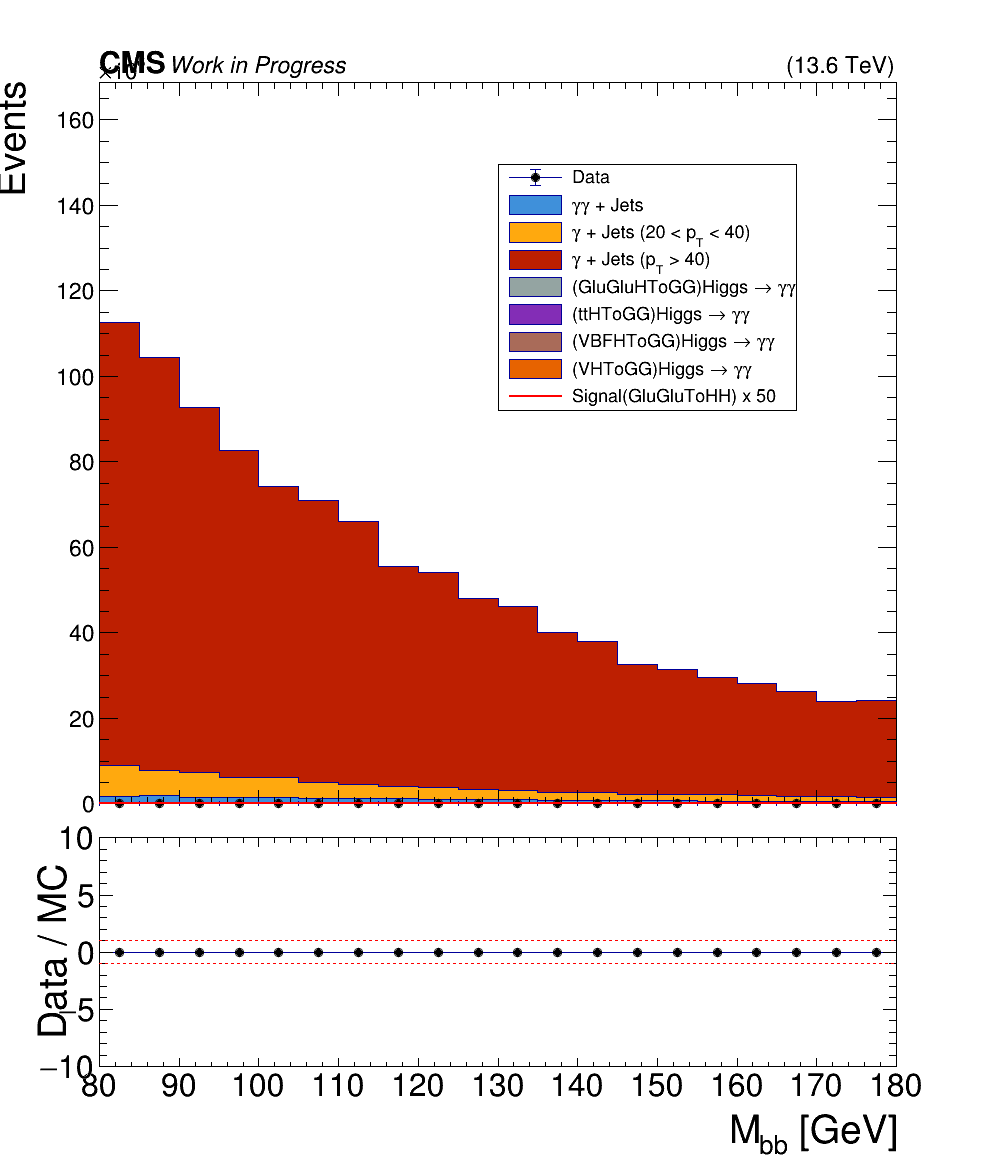

In [25]:
# Create a canvas
canvas = ROOT.TCanvas("canvas", "Invariant Mass", 1000, 1200)

# Adjust canvas to include ratio plot
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)  # join pad1 and pad2
pad1.SetTopMargin(0.1)  # increase the top margin
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

# Draw the background histograms
stack = ROOT.THStack("stack", " ")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

# Draw the stack
stack.Draw("HIST")

# Create a histogram for data invariant masses
hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass in data_invariant_masses:
    hist_data.Fill(mass)

# Set y-axis minimum to 0 and draw the histograms
stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.5)

# Remove x-axis label on the main plot
stack.GetXaxis().SetLabelSize(0)
stack.GetXaxis().SetTitleSize(0)

# Set y-axis label for the main plot
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.05)

stack.GetYaxis().SetTitleOffset(1.1)
stack.GetYaxis().SetLabelSize(0.03)


# Draw the stack and data histogram
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")


# Draw signal histogram
signal_hist.Draw("SAME HIST")


# # Add legend
# legend = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
# legend.AddEntry(hist_data, "Data", "lep")
# for bg_name, bg_hist in background_hists.items():
#     legend.AddEntry(bg_hist, bg_name, "f")
# legend.Draw()

# Add legend
legend = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(background_hists["GGJets"], "#gamma#gamma + Jets", "f")
legend.AddEntry(background_hists["GJetPt20To40"], "#gamma + Jets (20 < p_{T} < 40)", "f")
legend.AddEntry(background_hists["GJetPt40"], "#gamma + Jets (p_{T} > 40)", "f")
legend.AddEntry(background_hists["GluGluHToGG"], "(GluGluHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["ttHToGG"], "(ttHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VBFHToGG"], "(VBFHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VHToGG"], "(VHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(signal_hist, "Signal(GluGluToHH) x 50", "l")
legend.Draw()

# Draw CMS text
cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

# Draw "Work in Progress"
work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.17, 0.91, "Work in Progress")

# Draw energy information
energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.79, 0.91, "(13.6 TeV)")

# Set ticks on all sides with smaller size
stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)

# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

# Create a histogram for the ratio
hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")

hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)

# Remove statistics box from the ratio plot
hist_ratio.SetStats(0)

# Increase text size for labels and titles
hist_ratio.GetXaxis().SetLabelSize(0.1)
hist_ratio.GetXaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)

# Draw the ratio histogram
hist_ratio.Draw("ep")

# Add labels and title for the ratio plot
hist_ratio.GetXaxis().SetTitle("M_{bb} [GeV]")
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.25)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)


# Set y-axis range and divisions
hist_ratio.SetMinimum(-10)
hist_ratio.SetMaximum(10)  # Adjust maximum as needed
hist_ratio.GetYaxis().SetNdivisions(505)  # Increase divisions for better visibility

# Draw horizontal lines at y=1 and y=2
line1 = ROOT.TLine(80, -1, 180, -1)
line1.SetLineStyle(2)  # Dashed line
line1.SetLineColor(ROOT.kRed)
line1.Draw()

line2 = ROOT.TLine(80, 1, 180, 1)
line2.SetLineStyle(2)  # Dashed line
line2.SetLineColor(ROOT.kRed)
line2.Draw()

# # Save the canvas as a PDF file
canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding_higgs_Addition_signal_cross_section_genweights.pdf")

# Show the canvas
canvas.Draw()

# # Clear the canvas and histograms after saving the plot
# canvas.Clear()
# for bg_hist in background_hists.values():
#     bg_hist.Delete()
# hist_data.Delete()
# hist_ratio.Delete()
# mc_hist.Delete()

 Check the error\
